In [1]:
from unityagents import UnityEnvironment
from collections import deque

import numpy as np
import progressbar as pb

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

In [2]:
# 1 agent
env = UnityEnvironment(file_name="./Reacher_Windows_x86_64_1_agent/Reacher.exe")

# 20 agents
# env = UnityEnvironment(file_name="./Reacher_Windows_x86_64_20_agents/Reacher.exe")

# Crawler
# env = UnityEnvironment(file_name="./Crawler_Windows_x86_64/Crawler.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
pi = Variable(torch.FloatTensor([math.pi]), requires_grad=True).cuda()

def normal(x, mu, sigma_sq):
    a = (-1*(Variable(x, requires_grad=True)-mu).pow(2)/(2*sigma_sq)).exp()
    b = 1/(2*sigma_sq*pi.expand_as(sigma_sq)).sqrt()
    return a*b

def probs_to_actions(mu, sigma_sq):
    eps = torch.randn(mu.size())
    sigma_sq = torch.ones(mu.size()).cuda()
    action = (mu + sigma_sq.sqrt()*Variable(eps, requires_grad=True).cuda())
    prob = normal(action, mu, sigma_sq)
    
    return action.reshape(-1, 4), torch.log(prob).reshape(-1, 4)

In [7]:
class Policy(nn.Module):
    def __init__(self, state_size, action_size, n_agents=1, fc1_size=128, fc2_size=64, fc3_size=32):
        super(Policy, self).__init__()
        
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, fc3_size)
        
        self.fc4_mu = nn.Linear(fc3_size, action_size)
        self.fc4_sigma_squared = nn.Linear(fc3_size, action_size)
        
        self.n_agents = n_agents
        
    def forward(self, x):
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        mu = torch.tanh(self.fc4_mu(x))
        sigma = torch.sigmoid(self.fc4_sigma_squared(x))
        
        return mu, sigma
    
    def act(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.from_numpy(state).float().to(device)
        mu, sigma = self.forward(state)
        return probs_to_actions(mu, sigma)

In [8]:
class Value(nn.Module):
    """
        Critic network that estimates a Value Function used as a baseline
    """
    def __init__(self, state_size, action_size=1, n_agents=1, fc1_size=128, fc2_size=64, fc3_size=32):
        super(Value, self).__init__()
        
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, fc3_size)
        self.fc4 = nn.Linear(fc3_size, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)
    
    def estimate(self, state):
        state = torch.from_numpy(state).float().to(device)
        return self.forward(state)

In [9]:
def unroll_trajectory(env, brain_name, n_agents, t_max=1000, gamma=1.0):
    """
        Unroll a trajectory and return 
        list of action probabilities, states, actions and rewards

        Parameters
        ----------
        env: unityagents.UnityEnvironment
        Environment to play on.
        brain_name: String
        Name of brain used for UnityEnvironment
        policy: torch.nn.Module
        A neural network mapping states to action probabilities 
        The action to take at a given state
        t_max: int
        Maximum number of episodes in trajectory
    """
    
    env_info = env.reset(train_mode=True)[brain_name]
    
    state_list      = []
    reward_list     = []
    prob_list       = []
    action_list     = []
    values_list     = []
    advantages_list = []

    states = np.array(env_info.vector_observations).reshape(n_agents, -1)
    
    
    num_episodes = 0
    
    for _ in range(t_max):
        
        num_episodes += 1

        a, p = policy_network.act(states)
        actions = a.cpu().detach().numpy()
        action_probabilities = p
        
        env_info = env.step(actions)[brain_name]
        next_states = np.array(env_info.vector_observations).reshape(n_agents, -1)
        
        prob_list.append(action_probabilities)
        state_list.append(states)
        action_list.append(actions)
        
        rewards = torch.from_numpy(np.array(env_info.rewards).reshape(n_agents, -1)).float().to(device)
        reward_list.append(rewards)
        
        cur_value    = value_network.estimate(states)
        next_value   = value_network.estimate(next_states)
        
        if np.any(env_info.local_done):
            next_value = 0
        
        values       = rewards + gamma * cur_value
        values_list.append(values)
        
        advantages   = rewards + gamma * next_value - cur_value
        advantages_list.append(advantages)
        
        if np.any(env_info.local_done):
            break

        states = next_states

    return {
        "log_probs"  : torch.cat(prob_list).reshape(n_agents, num_episodes, -1),
        "states"     : np.array(state_list).reshape(n_agents, num_episodes, -1), 
        "actions"    : np.array(action_list).reshape(n_agents, num_episodes, -1),
        "rewards"    : torch.cat(reward_list).reshape(n_agents, num_episodes), 
        "values"     : torch.cat(values_list).reshape(n_agents, num_episodes), 
        "advantages" : torch.cat(advantages_list).reshape(n_agents, num_episodes),
        "num_episodes" : num_episodes,
    }

In [10]:
def ppo_loss(old_probs, states, A, epsilon=0.1):
    """
        Loss as defined in PPO algorithm

        Parameters
        ----------
        old_probs: torch.Tensor
        Tensor that defines log probabilities of actions under evaluated policy
        states: np.Array [n_agents x n_episoded x state_size] 
        signal: np.Array [n_agents x n_episoded x state_size] 
    """
    old_probs = old_probs.detach()
    _, new_probs = policy_network.act(states)
    new_probs = new_probs.reshape(old_probs.shape)        
    ratio = (new_probs/old_probs)    
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    
    loss_cat = []
    
    for n_agent in range(ratio.shape[0]):
        ratio_ = ratio[n_agent]
        clip_ = clip[n_agent]
        a_ = A[n_agent]
        
        ratio_ = ratio_ * a_.data[0]
        clip_ = clip_ * a_.data[0]
        loss_cat.append(torch.min(ratio_, clip_).mean())
    
    return -torch.stack(loss_cat).mean()

In [12]:
def a3c(n_episodes=1000, max_t=2000, print_every=100, n_pp_iterations=300):
    widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA() ]
    timer = pb.ProgressBar(widgets=widget, maxval=n_episodes).start()
    
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        
        trajectory = unroll_trajectory(env, brain_name, num_agents, max_t)
        num_episodes = trajectory['num_episodes']

        mean_rewards = trajectory['rewards'].sum(1).mean().detach().cpu().numpy()
        scores_deque.append(mean_rewards)
        scores.append(mean_rewards)
        
        R = torch.from_numpy(np.flip(np.flip(trajectory['rewards'].detach().cpu().numpy()).cumsum(1)).reshape(num_agents, num_episodes).copy()).float().to(device)
        A = trajectory['advantages'].reshape(R.shape).detach()

        states = torch.from_numpy(trajectory['states']).float().to(device)
        for i in range(n_pp_iterations):
            value_loss = value_criterion(
                value_network(states).reshape(num_agents, num_episodes), 
                trajectory['rewards']
            )
            value_optimizer.zero_grad()
            value_loss.backward()
            value_optimizer.step()

        for i in range(n_pp_iterations):
            policy_loss = ppo_loss(trajectory['log_probs'], states, A)
            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
        if np.mean(scores_deque)>=30.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
            
        timer.update(i_episode)
        
    return scores

In [13]:
policy_network   = Policy(state_size=state_size, action_size=action_size).to(device)
policy_optimizer = optim.Adam(policy_network.parameters(), lr=5e-4)

value_network    = Value(state_size=state_size, action_size=1).to(device)
value_criterion  = nn.MSELoss()
value_optimizer  = optim.Adam(value_network.parameters(), lr=5e-4)

%time scores = a3c(n_episodes=int(5e2), max_t=int(2e5), print_every=100)

Episode 100	Average Score: 0.59


Episode 200	Average Score: 0.94


Episode 300	Average Score: 0.93


Episode 400	Average Score: 0.88


Episode 500	Average Score: 0.79
Wall time: 2h 5min 48s


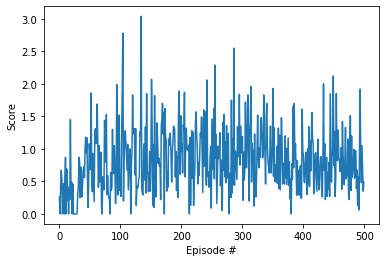

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [15]:
env.close()